# 009.001 Modeling - Calibrated Classifiers

In [1]:
import pathlib
import sys
import joblib

import pandas as pd
import numpy as np
import missingno as msno

# import scipy.stats as stats
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from scipy.stats import poisson, nbinom


import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker
# import seaborn as sns

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload all modules
%autoreload 2
#add the 'src' directory to path to import modules
PROJECT_DIR = pathlib.Path.cwd().resolve().parent
sys.path.append(str(PROJECT_DIR))

from src.visualization.visualize import get_model_diagnosis
from src.visualization.visualize import extend_cols
from src.data.transform_long_to_wide import run_transform_ts_to_supervised
from src.data.transformed_to_all_stacked import transformed_to_all_stacked
from src.data.stacked_to_ts_featured import clean_df
from src.models.metrics import insert_rps
from src.betting.simulate import simulate_betting

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

SAMPLE_DIR = PROJECT_DIR / 'data' / 'sample'
SAMP_STACKED_DIR = SAMPLE_DIR / '01-stacked-seasons'
SAMP_FEATURED_DIR = SAMPLE_DIR / '02-featured'
SAMP_TRANSFORMED_DIR = SAMPLE_DIR / '03-transformed'

# fn = '2007-2008__2017-2018.csv'
# EDA_FP = SAMPLE_DIR / '01-stacked-seasons' / 'germany' / 'bundesliga' / fn
# SAVED_IMAGES_DIR = PROJECT_DIR / 'notebooks' / 'saved-images'

fn = '2007-2008__2017-2018.csv'
SAMP_STACKED_FP = SAMP_STACKED_DIR / 'germany' / 'bundesliga' / fn
SAMP_FEATURED_FP = SAMP_FEATURED_DIR / 'germany' / 'bundesliga' / fn
SAMP_TRANSFORMED_FP = SAMP_TRANSFORMED_DIR / 'germany' / 'bundesliga' / fn
SAMP_MODEL_FP = SAMPLE_DIR / 'models' / 'optimized-model.joblib'
SAMP_CAL_FP = SAMPLE_DIR / 'models' / 'calibration-model.joblib'
SAVE_FP = SAMPLE_DIR / 'check-output' / 'test.csv'

In [2]:
SAMP_FEATURED_SUBDIRS  = str(SAMP_FEATURED_DIR) + '/*/'
SAMP_TRANSFORMED_SUBDIRS = str(SAMP_TRANSFORMED_DIR) + '/*/' 

In [3]:
!tree $SAMPLE_DIR -n

/media/david/5C14F53A14F517AA/code/ana_py37/projects/soccer-predictions/data/sample
├── 01-stacked-seasons
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 02-featured
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 03-transformed
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 04-all-stacked
│   ├── 2007-2008__2009-2010.csv
│   ├── 2007-2008__2017-2018.csv
│   ├── germany
│   │   └── bundesliga
│   │       └── 2007-2008__2017-2018.csv
│   └── italy
│       └── serie-a
│           └── 2010-2011__2017-2018.csv
├── check-output
│   └── test.csv
└── models
    ├── calibration-model.joblib
    ├── good-calibration-model.joblib
    └── optimized-model.joblib

16 directories, 11 files


## 1. Select Features

In [4]:
df_trans = pd.read_csv(SAMP_TRANSFORMED_FP,
                       parse_dates=['date']).sort_values(by=['date', 'h', 'a']).reset_index(drop=True)
# Sort the features

In [5]:
df_temp = df_trans.copy(deep=True)

from src.features.manipulation import (cut_historical_games,
                                       select_features,
                                       get_feature_name_stubs_from_base,
                                       get_base_features,
                                       get_df_from_base_features,
                                       get_features_df,
                                       get_non_features_df,
                                       get_target_df)

In [6]:
base_features = get_base_features(df_temp)
base_features

['corners',
 'fouls',
 'ftGoals',
 'htGoals',
 'impliedDraw',
 'impliedLose',
 'impliedWin',
 'poissDraw',
 'poissLose',
 'poissWin',
 'redCards',
 'shots',
 'shotsOnTarget',
 'yellowCards']

In [7]:
selected_base_features = base_features
df_select_features = get_df_from_base_features(df_trans, selected_base_features)
df_select_features.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_corners-0,h_h_corners-0,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_corners-3,a_h_corners-3,h_a_corners-3,h_h_corners-3,a_a_corners-4,a_h_corners-4,h_a_corners-4,h_h_corners-4,a_a_corners-5,a_h_corners-5,h_a_corners-5,h_h_corners-5,a_a_corners-6,a_h_corners-6,h_a_corners-6,h_h_corners-6,a_a_corners-7,a_h_corners-7,h_a_corners-7,h_h_corners-7,a_a_corners-8,a_h_corners-8,h_a_corners-8,h_h_corners-8,a_a_corners-9,a_h_corners-9,h_a_corners-9,h_h_corners-9,a_a_corners-10,a_h_corners-10,h_a_corners-10,h_h_corners-10,a_a_corners-11,a_h_corners-11,h_a_corners-11,h_h_corners-11,a_a_corners-12,a_h_corners-12,h_a_corners-12,h_h_corners-12,a_a_corners-13,a_h_corners-13,h_a_corners-13,h_h_corners-13,a_a_corners-14,a_h_corners-14,h_a_corners-14,h_h_corners-14,a_a_corners-15,a_h_corners-15,h_a_corners-15,h_h_corners-15,a_a_corners-16,a_h_corners-16,h_a_corners-16,h_h_corners-16,a_h_corners-17,h_a_corners-17,a_a_fouls-0,h_h_fouls-0,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_fouls-3,a_h_fouls-3,h_a_fouls-3,h_h_fouls-3,a_a_fouls-4,a_h_fouls-4,h_a_fouls-4,h_h_fouls-4,a_a_fouls-5,a_h_fouls-5,h_a_fouls-5,h_h_fouls-5,a_a_fouls-6,a_h_fouls-6,h_a_fouls-6,h_h_fouls-6,a_a_fouls-7,a_h_fouls-7,h_a_fouls-7,h_h_fouls-7,a_a_fouls-8,a_h_fouls-8,h_a_fouls-8,h_h_fouls-8,a_a_fouls-9,a_h_fouls-9,h_a_fouls-9,h_h_fouls-9,a_a_fouls-10,a_h_fouls-10,h_a_fouls-10,h_h_fouls-10,a_a_fouls-11,a_h_fouls-11,h_a_fouls-11,h_h_fouls-11,a_a_fouls-12,a_h_fouls-12,h_a_fouls-12,h_h_fouls-12,a_a_fouls-13,a_h_fouls-13,h_a_fouls-13,h_h_fouls-13,a_a_fouls-14,a_h_fouls-14,h_a_fouls-14,h_h_fouls-14,a_a_fouls-15,a_h_fouls-15,h_a_fouls-15,h_h_fouls-15,a_a_fouls-16,a_h_fouls-16,h_a_fouls-16,h_h_fouls-16,a_h_fouls-17,h_a_fouls-17,a_a_ftGoals-0,h_h_ftGoals-0,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_ftGoals-3,a_h_ftGoals-3,h_a_ftGoals-3,h_h_ftGoals-3,a_a_ftGoals-4,a_h_ftGoals-4,h_a_ftGoals-4,h_h_ftGoals-4,a_a_ftGoals-5,a_h_ftGoals-5,h_a_ftGoals-5,h_h_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-6,h_a_ftGoals-6,h_h_ftGoals-6,a_a_ftGoals-7,a_h_ftGoals-7,h_a_ftGoals-7,h_h_ftGoals-7,a_a_ftGoals-8,a_h_ftGoals-8,h_a_ftGoals-8,h_h_ftGoals-8,a_a_ftGoals-9,a_h_ftGoals-9,h_a_ftGoals-9,h_h_ftGoals-9,a_a_ftGoals-10,a_h_ftGoals-10,h_a_ftGoals-10,h_h_ftGoals-10,a_a_ftGoals-11,a_h_ftGoals-11,h_a_ftGoals-11,h_h_ftGoals-11,a_a_ftGoals-12,a_h_ftGoals-12,h_a_ftGoals-12,h_h_ftGoals-12,a_a_ftGoals-13,a_h_ftGoals-13,h_a_ftGoals-13,h_h_ftGoals-13,a_a_ftGoals-14,...,a_h_shots-3,a_h_shotsOnTarget-3,h_a_shots-3,h_a_shotsOnTarget-3,h_h_shots-3,h_h_shotsOnTarget-3,a_a_shots-4,a_a_shotsOnTarget-4,a_h_shots-4,a_h_shotsOnTarget-4,h_a_shots-4,h_a_shotsOnTarget-4,h_h_shots-4,h_h_shotsOnTarget-4,a_a_shots-5,a_a_shotsOnTarget-5,a_h_shots-5,a_h_shotsOnTarget-5,h_a_shots-5,h_a_shotsOnTarget-5,h_h_shots-5,h_h_shotsOnTarget-5,a_a_shots-6,a_a_shotsOnTarget-6,a_h_shots-6,a_h_shotsOnTarget-6,h_a_shots-6,h_a_shotsOnTarget-6,h_h_shots-6,h_h_shotsOnTarget-6,a_a_shots-7,a_a_shotsOnTarget-7,a_h_shots-7,a_h_shotsOnTarget-7,h_a_shots-7,h_a_shotsOnTarget-7,h_h_shots-7,h_h_shotsOnTarget-7,a_a_shots-8,a_a_shotsOnTarget-8,a_h_shots-8,a_h_shotsOnTarget-8,h_a_shots-8,h_a_shotsOnTarget-8,h

## 2. Select Number of Past Games to Get

Select all features for the last n games defined in `n_back`

We can either drop all games where the teams have not played, or we can impute

This is quite a big notebook, so for the sake of brevity we will drop all games unless each team has played n previous games


In [8]:
n_back=5
df_cut = cut_historical_games(df_select_features, n_back=n_back, drop_all_nan_rows=True, how='any')
df_cut.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_impliedDraw-0,h_h_impliedDraw-0,a_a_impliedDraw-1,a_h_impliedDraw-1,h_a_impliedDraw-1,h_h_impliedDraw-1,a_a_impliedDraw-2,a_h_impliedDraw-2,h_a_impliedDraw-2,h_h_impliedDraw-2,a_a_impliedDraw-3,a_h_impliedDraw-3,h_a_impliedDraw-3,h_h_impliedDraw-3,a_a_impliedDraw-4,a_h_impliedDraw-4,h_a_impliedDraw-4,h_h_impliedDraw-4,a_a_impliedDraw-5,a_h_impliedDraw-5,h_a_impliedDraw-5,h_h_impliedDraw-5,a_a_impliedLose-0,h_h_impliedLose-0,a_a_impliedLose-1,a_h_impliedLose-1,h_a_impliedLose-1,h_h_impliedLose-1,a_a_impliedLose-2,a_h_impliedLose-2,h_a_impliedLose-2,h_h_impliedLose-2,a_a_impliedLose-3,a_h_impliedLose-3,h_a_impliedLose-3,h_h_impliedLose-3,a_a_impliedLose-4,a_h_impliedLose-4,h_a_impliedLose-4,h_h_impliedLose-4,a_a_impliedLose-5,a_h_impliedLose-5,h_a_impliedLose-5,h_h_impliedLose-5,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_impliedWin-3,a_h_impliedWin-3,h_a_impliedWin-3,h_h_impliedWin-3,a_a_impliedWin-4,a_h_impliedWin-4,h_a_impliedWin-4,h_h_impliedWin-4,a_a_impliedWin-5,a_h_impliedWin-5,h_a_impliedWin-5,h_h_impliedWin-5,a_a_poissDraw-0,h_h_poissDraw-0,a_a_poissDraw-1,a_h_poissDraw-1,h_a_poissDraw-1,h_h_poissDraw-1,a_a_poissDraw-2,a_h_poissDraw-2,h_a_poissDraw-2,h_h_poissDraw-2,a_a_poissDraw-3,a_h_poissDraw-3,h_a_poissDraw-3,h_h_poissDraw-3,a_a_poissDraw-4,a_h_poissDraw-4,h_a_poissDraw-4,h_h_poissDraw-4,a_a_poissDraw-5,a_h_poissDraw-5,h_a_poissDraw-5,h_h_poissDraw-5,a_a_poissLose-0,h_h_poissLose-0,a_a_poissLose-1,a_h_poissLose-1,h_a_poissLose-1,h_h_poissLose-1,a_a_poissLose-2,a_h_poissLose-2,h_a_poissLose-2,h_h_poissLose-2,a_a_poissLose-3,a_h_poissLose-3,h_a_poissLose-3,h_h_poissLose-3,a_a_poissLose-4,a_h_poissLose-4,h_a_poissLose-4,h_h_poissLose-4,a_a_poissLose-5,a_h_poissLose-5,h_a_poissLose-5,h_h_poissLose-5,a_a_poissWin-0,h_h_poissWin-0,a_a_poissWin-1,a_h_poissWin-1,h_a_poissWin-1,h_h_poissWin-1,a_a_poissWin-2,a_h_poissWin-2,h_a_poissWin-2,h_h_poissWin-2,a_a_poissWin-3,a_h_poissWin-3,h_a_poissWin-3,h_h_poissWin-3,a_a_poissWin-4,a_h_poissWin-4,h_a_poissWin-4,h_h_poissWin-4,a_a_poissWin-5,a_h_poissWin-5,h_a_poissWin-5,h_h_poissWin-5,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_corners-3,a_h_corners-3,h_a_corners-3,h_h_corners-3,a_a_corners-4,a_h_corners-4,h_a_corners-4,h_h_corners-4,a_a_corners-5,a_h_corners-5,h_a_corners-5,h_h_corners-5,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_fouls-3,a_h_fouls-3,h_a_fouls-3,h_h_fouls-3,a_a_fouls-4,a_h_fouls-4,h_a_fouls-4,h_h_fouls-4,a_a_fouls-5,a_h_fouls-5,h_a_fouls-5,h_h_fouls-5,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_ftGoals-3,a_h_ftGoals-3,h_a_ftGoals-3,h_h_ftGoals-3,a_a_ftGoals-4,a_h_ftGoals-4,h_a_ftGoals-4,h_h_ftGoals-4,a_a_ftGoals-5,a_h_ftGoals-5,h_a_ftGoals-5,h_h_ftGoals-5,a_a_htGoals-1,a_h_htGoals-1,h_a_htGoals-1,h_h_htGoals-1,a_a_htGoals-2,a_h_htGoals-2,h_a_htGoals-2,h_h_htGoals-2,a_a_htGoals-3,a_h_htGoals-3,h_a_htGoals-3,h_h_htGoals-3,a_a_htGoals-4,a_h_htGoals-4,h_a_htGoals-4,h_h_htGoals-4,a_a_htGoals-5,a_h_htGoals-5,h_a_htGoals-5,h_h_htGoals-5,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1

## 3. Prepare data For Modeling

### Prepare for Data Splitting

Prior to modeling, we will split the DataFrame into 3 parts, all keeping the same row index
+ meta - all meta data
+ X - all features
+ y - target

In [9]:
df_model = df_cut.copy(deep=True)
# Reset index prior to any splitting
df_model = df_model.sort_values(by=['date'])
df_model = df_model.reset_index(drop=True)
meta = get_non_features_df(df_model)
meta.head(2)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight
0,germany,bundesliga,2007-2008,hannover,schalke,2007-11-24,2.0,3.0,awin,6.0,18.0,1.0,0.284534,0.354326,0.36114,0.302742,0.360347,0.336911,0.0,17.0,8.0,2.0,2.6,2.50,2.7,2.55,0.275,0.275,0.45,3.3,3.2,3.35,3.19,3.0,15.0,1.0,0.284534,0.36114,0.354326,0.302742,0.336911,0.360347,0.0,12.0,4.0,2.0,2.65,2.60,2.95,2.62,0.36114,0.284534,0.354326,3,0,0,1,0.405229,1.0
1,germany,bundesliga,2007-2008,hansa-rostock,hannover,2007-11-30,0.0,3.0,awin,7.0,20.0,0.0,0.284091,0.340909,0.37500,0.284063,0.364844,0.351093,0.0,19.0,10.0,1.0,2.5,2.45,2.6,2.49,0.275,0.275,0.45,3.3,3.2,3.30,3.20,6.0,12.0,0.0,0.284091,0.37500,0.340909,0.284063,0.351093,0.364844,0.0,17.0,5.0,1.0,2.75,2.65,3.05,2.68,0.37500,0.284091,0.340909,3,0,0,1,0.415033,1.0


In [10]:
meta.tail(2)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight
2014,germany,bundesliga,2017-2018,hoffenheim,dortmund,2018-05-12,3.0,1.0,hwin,3.0,7.0,0.0,0.250874,0.432188,0.316938,0.201886,0.499142,0.298946,0.0,10.0,4.0,0.0,3.00,3.0,3.13,2.95,0.275,0.275,0.45,3.79,3.8,4.25,3.97,2.0,4.0,1.0,0.250874,0.316938,0.432188,0.201886,0.298946,0.499142,0.0,12.0,8.0,0.0,2.20,2.20,2.4,2.18,0.316938,0.250874,0.432188,1,1,0,0,1.0,0.611111
2015,germany,bundesliga,2017-2018,wolfsburg,fc-koln,2018-05-12,4.0,1.0,hwin,10.0,17.0,1.0,0.238043,0.580592,0.181366,0.247620,0.544556,0.207823,0.0,6.0,1.0,3.0,5.25,5.0,5.50,4.98,0.275,0.275,0.45,4.00,4.1,4.36,4.11,5.0,12.0,1.0,0.238043,0.181366,0.580592,0.247620,0.207823,0.544556,0.0,16.0,8.0,2.0,1.64,1.65,1.7,1.64,0.181366,0.238043,0.580592,1,1,0,0,1.0,0.611111


In [11]:
meta.shape

(2016, 59)

In [12]:
X = get_features_df(df_model)
X.head(2)

,a_a_impliedDraw-0,h_h_impliedDraw-0,a_a_impliedDraw-1,a_h_impliedDraw-1,h_a_impliedDraw-1,h_h_impliedDraw-1,a_a_impliedDraw-2,a_h_impliedDraw-2,h_a_impliedDraw-2,h_h_impliedDraw-2,a_a_impliedDraw-3,a_h_impliedDraw-3,h_a_impliedDraw-3,h_h_impliedDraw-3,a_a_impliedDraw-4,a_h_impliedDraw-4,h_a_impliedDraw-4,h_h_impliedDraw-4,a_a_impliedDraw-5,a_h_impliedDraw-5,h_a_impliedDraw-5,h_h_impliedDraw-5,a_a_impliedLose-0,h_h_impliedLose-0,a_a_impliedLose-1,a_h_impliedLose-1,h_a_impliedLose-1,h_h_impliedLose-1,a_a_impliedLose-2,a_h_impliedLose-2,h_a_impliedLose-2,h_h_impliedLose-2,a_a_impliedLose-3,a_h_impliedLose-3,h_a_impliedLose-3,h_h_impliedLose-3,a_a_impliedLose-4,a_h_impliedLose-4,h_a_impliedLose-4,h_h_impliedLose-4,a_a_impliedLose-5,a_h_impliedLose-5,h_a_impliedLose-5,h_h_impliedLose-5,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_impliedWin-3,a_h_impliedWin-3,h_a_impliedWin-3,h_h_impliedWin-3,a_a_impliedWin-4,a_h_impliedWin-4,h_a_impliedWin-4,h_h_impliedWin-4,a_a_impliedWin-5,a_h_impliedWin-5,h_a_impliedWin-5,h_h_impliedWin-5,a_a_poissDraw-0,h_h_poissDraw-0,a_a_poissDraw-1,a_h_poissDraw-1,h_a_poissDraw-1,h_h_poissDraw-1,a_a_poissDraw-2,a_h_poissDraw-2,h_a_poissDraw-2,h_h_poissDraw-2,a_a_poissDraw-3,a_h_poissDraw-3,h_a_poissDraw-3,h_h_poissDraw-3,a_a_poissDraw-4,a_h_poissDraw-4,h_a_poissDraw-4,h_h_poissDraw-4,a_a_poissDraw-5,a_h_poissDraw-5,h_a_poissDraw-5,h_h_poissDraw-5,a_a_poissLose-0,h_h_poissLose-0,a_a_poissLose-1,a_h_poissLose-1,h_a_poissLose-1,h_h_poissLose-1,a_a_poissLose-2,a_h_poissLose-2,h_a_poissLose-2,h_h_poissLose-2,a_a_poissLose-3,a_h_poissLose-3,h_a_poissLose-3,h_h_poissLose-3,a_a_poissLose-4,a_h_poissLose-4,h_a_poissLose-4,h_h_poissLose-4,a_a_poissLose-5,a_h_poissLose-5,h_a_poissLose-5,h_h_poissLose-5,a_a_poissWin-0,h_h_poissWin-0,a_a_poissWin-1,a_h_poissWin-1,h_a_poissWin-1,h_h_poissWin-1,a_a_poissWin-2,a_h_poissWin-2,h_a_poissWin-2,h_h_poissWin-2,a_a_poissWin-3,a_h_poissWin-3,h_a_poissWin-3,h_h_poissWin-3,a_a_poissWin-4,a_h_poissWin-4,h_a_poissWin-4,h_h_poissWin-4,a_a_poissWin-5,a_h_poissWin-5,h_a_poissWin-5,h_h_poissWin-5,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_corners-3,a_h_corners-3,h_a_corners-3,h_h_corners-3,a_a_corners-4,a_h_corners-4,h_a_corners-4,h_h_corners-4,a_a_corners-5,a_h_corners-5,h_a_corners-5,h_h_corners-5,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_fouls-3,a_h_fouls-3,h_a_fouls-3,h_h_fouls-3,a_a_fouls-4,a_h_fouls-4,h_a_fouls-4,h_h_fouls-4,a_a_fouls-5,a_h_fouls-5,h_a_fouls-5,h_h_fouls-5,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_ftGoals-3,a_h_ftGoals-3,h_a_ftGoals-3,h_h_ftGoals-3,a_a_ftGoals-4,a_h_ftGoals-4,h_a_ftGoals-4,h_h_ftGoals-4,a_a_ftGoals-5,a_h_ftGoals-5,h_a_ftGoals-5,h_h_ftGoals-5,a_a_htGoals-1,a_h_htGoals-1,h_a_htGoals-1,h_h_htGoals-1,a_a_htGoals-2,a_h_htGoals-2,h_a_htGoals-2,h_h_htGoals-2,a_a_htGoals-3,a_h_htGoals-3,h_a_htGoals-3,h_h_htGoals-3,a_a_htGoals-4,a_h_htGoals-4,h_a_htGoals-4,h_h_htGoals-4,a_a_htGoals-5,a_h_htGoals-5,h_a_htGoals-5,h_h_htGoals-5,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_redCards-2,a_h_redCards-2,h_a_redCards-2,h_h_redCards-2,a_a_redCards-3,a_h_redCards-3,h_a_redCards-3,h_h_redCards-3,a_a_redCards-4,a_h_redCards-4,h_a_redCards-4,h_h_redCards-4,a_a_redCards-5,a_h_redCards-5,h_a_redCards-5,h_h_redCards-5,a_a_shots-1,a_a_shotsOnTarget-1,a_h_shots-1,a_h_shotsOnTarget-1,h_a_shots-1,h_a_shotsOnTarget-1,h_h_shots-1,h_h_shotsOnTarget-1,a_a_shots-2,a_a_shotsOnTarget-2,a_h_shots-2,a_h_shotsOnTarget-2,h_a_shots-2,h_a_shotsOnTarget-2,h_h_shots-2,h_h_shotsOnTarget-2,a_a_shots-3,a_a_shotsOnTarget-3,a_h_shots-3,a_h_shotsOnTarget-3,h_a_shots-3,h_a_shotsOnTarget-3,h_h_shots-3,h_h_shotsOnTarget-3,a_a_shots-4,a_a_shotsOnTarget-4,a_h

In [13]:
X.shape

(2016, 292)

In [14]:
y = get_target_df(df_model, format='single_ordinal_result_column')
y.head(2)

0    3
1    3
Name: ordinal_result, dtype: int64

In [15]:
y.shape

(2016,)

### Split Into Train Test

In [16]:
test_seasons = ['2016-2017', '2017-2018']

train_full_index = meta[~meta['season'].isin(test_seasons)].index
held_out_test_index = meta[meta['season'].isin(test_seasons)].index

meta_train_full = meta.loc[train_full_index, :]
meta_held_out_test = meta.loc[held_out_test_index, :]

X_train_full = X.loc[train_full_index, :]
X_held_out_test = X.loc[held_out_test_index, :]

y_train_full = y.loc[train_full_index]
y_held_out_test = y.loc[held_out_test_index]

In [17]:
print(meta_train_full.shape)
print(X_train_full.shape)
print(y_train_full.shape)
print()
print(meta_held_out_test.shape)
print(X_held_out_test.shape)
print(y_held_out_test.shape)

(1654, 59)
(1654, 292)
(1654,)

(362, 59)
(362, 292)
(362,)


In [18]:
X_held_out_test.head()

,a_a_impliedDraw-0,h_h_impliedDraw-0,a_a_impliedDraw-1,a_h_impliedDraw-1,h_a_impliedDraw-1,h_h_impliedDraw-1,a_a_impliedDraw-2,a_h_impliedDraw-2,h_a_impliedDraw-2,h_h_impliedDraw-2,a_a_impliedDraw-3,a_h_impliedDraw-3,h_a_impliedDraw-3,h_h_impliedDraw-3,a_a_impliedDraw-4,a_h_impliedDraw-4,h_a_impliedDraw-4,h_h_impliedDraw-4,a_a_impliedDraw-5,a_h_impliedDraw-5,h_a_impliedDraw-5,h_h_impliedDraw-5,a_a_impliedLose-0,h_h_impliedLose-0,a_a_impliedLose-1,a_h_impliedLose-1,h_a_impliedLose-1,h_h_impliedLose-1,a_a_impliedLose-2,a_h_impliedLose-2,h_a_impliedLose-2,h_h_impliedLose-2,a_a_impliedLose-3,a_h_impliedLose-3,h_a_impliedLose-3,h_h_impliedLose-3,a_a_impliedLose-4,a_h_impliedLose-4,h_a_impliedLose-4,h_h_impliedLose-4,a_a_impliedLose-5,a_h_impliedLose-5,h_a_impliedLose-5,h_h_impliedLose-5,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_impliedWin-3,a_h_impliedWin-3,h_a_impliedWin-3,h_h_impliedWin-3,a_a_impliedWin-4,a_h_impliedWin-4,h_a_impliedWin-4,h_h_impliedWin-4,a_a_impliedWin-5,a_h_impliedWin-5,h_a_impliedWin-5,h_h_impliedWin-5,a_a_poissDraw-0,h_h_poissDraw-0,a_a_poissDraw-1,a_h_poissDraw-1,h_a_poissDraw-1,h_h_poissDraw-1,a_a_poissDraw-2,a_h_poissDraw-2,h_a_poissDraw-2,h_h_poissDraw-2,a_a_poissDraw-3,a_h_poissDraw-3,h_a_poissDraw-3,h_h_poissDraw-3,a_a_poissDraw-4,a_h_poissDraw-4,h_a_poissDraw-4,h_h_poissDraw-4,a_a_poissDraw-5,a_h_poissDraw-5,h_a_poissDraw-5,h_h_poissDraw-5,a_a_poissLose-0,h_h_poissLose-0,a_a_poissLose-1,a_h_poissLose-1,h_a_poissLose-1,h_h_poissLose-1,a_a_poissLose-2,a_h_poissLose-2,h_a_poissLose-2,h_h_poissLose-2,a_a_poissLose-3,a_h_poissLose-3,h_a_poissLose-3,h_h_poissLose-3,a_a_poissLose-4,a_h_poissLose-4,h_a_poissLose-4,h_h_poissLose-4,a_a_poissLose-5,a_h_poissLose-5,h_a_poissLose-5,h_h_poissLose-5,a_a_poissWin-0,h_h_poissWin-0,a_a_poissWin-1,a_h_poissWin-1,h_a_poissWin-1,h_h_poissWin-1,a_a_poissWin-2,a_h_poissWin-2,h_a_poissWin-2,h_h_poissWin-2,a_a_poissWin-3,a_h_poissWin-3,h_a_poissWin-3,h_h_poissWin-3,a_a_poissWin-4,a_h_poissWin-4,h_a_poissWin-4,h_h_poissWin-4,a_a_poissWin-5,a_h_poissWin-5,h_a_poissWin-5,h_h_poissWin-5,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_corners-3,a_h_corners-3,h_a_corners-3,h_h_corners-3,a_a_corners-4,a_h_corners-4,h_a_corners-4,h_h_corners-4,a_a_corners-5,a_h_corners-5,h_a_corners-5,h_h_corners-5,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_fouls-3,a_h_fouls-3,h_a_fouls-3,h_h_fouls-3,a_a_fouls-4,a_h_fouls-4,h_a_fouls-4,h_h_fouls-4,a_a_fouls-5,a_h_fouls-5,h_a_fouls-5,h_h_fouls-5,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_ftGoals-3,a_h_ftGoals-3,h_a_ftGoals-3,h_h_ftGoals-3,a_a_ftGoals-4,a_h_ftGoals-4,h_a_ftGoals-4,h_h_ftGoals-4,a_a_ftGoals-5,a_h_ftGoals-5,h_a_ftGoals-5,h_h_ftGoals-5,a_a_htGoals-1,a_h_htGoals-1,h_a_htGoals-1,h_h_htGoals-1,a_a_htGoals-2,a_h_htGoals-2,h_a_htGoals-2,h_h_htGoals-2,a_a_htGoals-3,a_h_htGoals-3,h_a_htGoals-3,h_h_htGoals-3,a_a_htGoals-4,a_h_htGoals-4,h_a_htGoals-4,h_h_htGoals-4,a_a_htGoals-5,a_h_htGoals-5,h_a_htGoals-5,h_h_htGoals-5,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_redCards-2,a_h_redCards-2,h_a_redCards-2,h_h_redCards-2,a_a_redCards-3,a_h_redCards-3,h_a_redCards-3,h_h_redCards-3,a_a_redCards-4,a_h_redCards-4,h_a_redCards-4,h_h_redCards-4,a_a_redCards-5,a_h_redCards-5,h_a_redCards-5,h_h_redCards-5,a_a_shots-1,a_a_shotsOnTarget-1,a_h_shots-1,a_h_shotsOnTarget-1,h_a_shots-1,h_a_shotsOnTarget-1,h_h_shots-1,h_h_shotsOnTarget-1,a_a_shots-2,a_a_shotsOnTarget-2,a_h_shots-2,a_h_shotsOnTarget-2,h_a_shots-2,h_a_shotsOnTarget-2,h_h_shots-2,h_h_shotsOnTarget-2,a_a_shots-3,a_a_shotsOnTarget-3,a_h_shots-3,a_h_shotsOnTarget-3,h_a_shots-3,h_a_shotsOnTarget-3,h_h_shots-3,h_h_shotsOnTarget-3,a_a_shots-4,a_a_shotsOnTarget-4,a_h

### Split Out Calibrate - In this case, we don't split out any data for calibration - Not using calibration in this Notebook

In [19]:
cal_seasons = []

train_val_index = meta_train_full[~meta_train_full['season'].isin(cal_seasons)].index
cal_index = meta_train_full[meta_train_full['season'].isin(cal_seasons)].index

meta_train_val = meta_train_full.loc[train_val_index, :]
meta_cal = meta_train_full.loc[cal_index, :]

X_train_val = X_train_full.loc[train_val_index, :]
X_cal = X_train_full.loc[cal_index, :]

y_train_val = y_train_full.loc[train_val_index]
y_cal = y_train_full.loc[cal_index]

In [20]:
print(meta_train_val.shape)
print(X_train_val.shape)
print(y_train_val.shape)
print()
print(meta_cal.shape)
print(X_cal.shape)
print(y_cal.shape)

(1654, 59)
(1654, 292)
(1654,)

(0, 59)
(0, 292)
(0,)


In [21]:
X_train_val.head()

,a_a_impliedDraw-0,h_h_impliedDraw-0,a_a_impliedDraw-1,a_h_impliedDraw-1,h_a_impliedDraw-1,h_h_impliedDraw-1,a_a_impliedDraw-2,a_h_impliedDraw-2,h_a_impliedDraw-2,h_h_impliedDraw-2,a_a_impliedDraw-3,a_h_impliedDraw-3,h_a_impliedDraw-3,h_h_impliedDraw-3,a_a_impliedDraw-4,a_h_impliedDraw-4,h_a_impliedDraw-4,h_h_impliedDraw-4,a_a_impliedDraw-5,a_h_impliedDraw-5,h_a_impliedDraw-5,h_h_impliedDraw-5,a_a_impliedLose-0,h_h_impliedLose-0,a_a_impliedLose-1,a_h_impliedLose-1,h_a_impliedLose-1,h_h_impliedLose-1,a_a_impliedLose-2,a_h_impliedLose-2,h_a_impliedLose-2,h_h_impliedLose-2,a_a_impliedLose-3,a_h_impliedLose-3,h_a_impliedLose-3,h_h_impliedLose-3,a_a_impliedLose-4,a_h_impliedLose-4,h_a_impliedLose-4,h_h_impliedLose-4,a_a_impliedLose-5,a_h_impliedLose-5,h_a_impliedLose-5,h_h_impliedLose-5,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_impliedWin-3,a_h_impliedWin-3,h_a_impliedWin-3,h_h_impliedWin-3,a_a_impliedWin-4,a_h_impliedWin-4,h_a_impliedWin-4,h_h_impliedWin-4,a_a_impliedWin-5,a_h_impliedWin-5,h_a_impliedWin-5,h_h_impliedWin-5,a_a_poissDraw-0,h_h_poissDraw-0,a_a_poissDraw-1,a_h_poissDraw-1,h_a_poissDraw-1,h_h_poissDraw-1,a_a_poissDraw-2,a_h_poissDraw-2,h_a_poissDraw-2,h_h_poissDraw-2,a_a_poissDraw-3,a_h_poissDraw-3,h_a_poissDraw-3,h_h_poissDraw-3,a_a_poissDraw-4,a_h_poissDraw-4,h_a_poissDraw-4,h_h_poissDraw-4,a_a_poissDraw-5,a_h_poissDraw-5,h_a_poissDraw-5,h_h_poissDraw-5,a_a_poissLose-0,h_h_poissLose-0,a_a_poissLose-1,a_h_poissLose-1,h_a_poissLose-1,h_h_poissLose-1,a_a_poissLose-2,a_h_poissLose-2,h_a_poissLose-2,h_h_poissLose-2,a_a_poissLose-3,a_h_poissLose-3,h_a_poissLose-3,h_h_poissLose-3,a_a_poissLose-4,a_h_poissLose-4,h_a_poissLose-4,h_h_poissLose-4,a_a_poissLose-5,a_h_poissLose-5,h_a_poissLose-5,h_h_poissLose-5,a_a_poissWin-0,h_h_poissWin-0,a_a_poissWin-1,a_h_poissWin-1,h_a_poissWin-1,h_h_poissWin-1,a_a_poissWin-2,a_h_poissWin-2,h_a_poissWin-2,h_h_poissWin-2,a_a_poissWin-3,a_h_poissWin-3,h_a_poissWin-3,h_h_poissWin-3,a_a_poissWin-4,a_h_poissWin-4,h_a_poissWin-4,h_h_poissWin-4,a_a_poissWin-5,a_h_poissWin-5,h_a_poissWin-5,h_h_poissWin-5,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_corners-3,a_h_corners-3,h_a_corners-3,h_h_corners-3,a_a_corners-4,a_h_corners-4,h_a_corners-4,h_h_corners-4,a_a_corners-5,a_h_corners-5,h_a_corners-5,h_h_corners-5,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_fouls-3,a_h_fouls-3,h_a_fouls-3,h_h_fouls-3,a_a_fouls-4,a_h_fouls-4,h_a_fouls-4,h_h_fouls-4,a_a_fouls-5,a_h_fouls-5,h_a_fouls-5,h_h_fouls-5,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_ftGoals-3,a_h_ftGoals-3,h_a_ftGoals-3,h_h_ftGoals-3,a_a_ftGoals-4,a_h_ftGoals-4,h_a_ftGoals-4,h_h_ftGoals-4,a_a_ftGoals-5,a_h_ftGoals-5,h_a_ftGoals-5,h_h_ftGoals-5,a_a_htGoals-1,a_h_htGoals-1,h_a_htGoals-1,h_h_htGoals-1,a_a_htGoals-2,a_h_htGoals-2,h_a_htGoals-2,h_h_htGoals-2,a_a_htGoals-3,a_h_htGoals-3,h_a_htGoals-3,h_h_htGoals-3,a_a_htGoals-4,a_h_htGoals-4,h_a_htGoals-4,h_h_htGoals-4,a_a_htGoals-5,a_h_htGoals-5,h_a_htGoals-5,h_h_htGoals-5,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_redCards-2,a_h_redCards-2,h_a_redCards-2,h_h_redCards-2,a_a_redCards-3,a_h_redCards-3,h_a_redCards-3,h_h_redCards-3,a_a_redCards-4,a_h_redCards-4,h_a_redCards-4,h_h_redCards-4,a_a_redCards-5,a_h_redCards-5,h_a_redCards-5,h_h_redCards-5,a_a_shots-1,a_a_shotsOnTarget-1,a_h_shots-1,a_h_shotsOnTarget-1,h_a_shots-1,h_a_shotsOnTarget-1,h_h_shots-1,h_h_shotsOnTarget-1,a_a_shots-2,a_a_shotsOnTarget-2,a_h_shots-2,a_h_shotsOnTarget-2,h_a_shots-2,h_a_shotsOnTarget-2,h_h_shots-2,h_h_shotsOnTarget-2,a_a_shots-3,a_a_shotsOnTarget-3,a_h_shots-3,a_h_shotsOnTarget-3,h_a_shots-3,h_a_shotsOnTarget-3,h_h_shots-3,h_h_shotsOnTarget-3,a_a_shots-4,a_a_shotsOnTarget-4,a_h

In [22]:
def run_fit_validate(X, y, meta_train_val, skf, srs, clf):
    n = 0
    validate_dfs = []
  

    for fit_indices, validate_indices in skf.split(X, y):

        X_fit = X.iloc[fit_indices]
        y_fit = y.iloc[fit_indices]

        X_validate = X.iloc[validate_indices]
        y_validate = y.iloc[validate_indices]

        meta_fit = meta_train_val.iloc[fit_indices]
        meta_validate = meta_train_val.iloc[validate_indices]

        X_fit = srs.fit_transform(X_fit)
        clf.fit(X_fit, y_fit)

        X_validate = srs.transform(X_validate)
        validate_preds = clf.predict_proba(X_validate)


        #Build the DataFrame with the results for the validation data
        validate_preds_df = pd.DataFrame(validate_preds, columns = clf.classes_, index = meta_validate.index)

        df_validate = pd.concat([meta_validate, X_validate, validate_preds_df], sort=False, axis=1)
        df_validate = insert_rps(df_validate)
        df_validate = insert_rps(df_validate,
                                 prob_cols=['implied_hwin', 'implied_draw', 'implied_awin'],
                                 return_col_prefix='bookie')
        df_validate = insert_rps(df_validate,
                                 prob_cols=['base_hwin_prob', 'base_draw_prob', 'base_awin_prob'],
                                 return_col_prefix='baseline')

        df_validate['pred_class'] = df_validate[[1,2, 3]].idxmax(axis=1)
        df_validate['pred_result'] = df_validate['pred_class'].map({1:'hwin', 2: 'draw', 3: 'awin'})
        
        df_validate['n_fold'] = n
        n += 1

        validate_dfs.append(df_validate)
    for df in validate_dfs:
        print(f"Validation Fold: {df['n_fold'].unique()[0]+1}")
        get_model_diagnosis(df, add_baseline=True)
        plt.show();
        print()
    return clf, validate_dfs

LogisticSE(alpha=1.0, max_iter=100000, verbose=0): 0



/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.2

Validation Fold: 1
Average Calibration Error:  0.564
Expected Calibration Error: 0.416
Maximum Calibration Error:  0.938
Number of Instances: 827


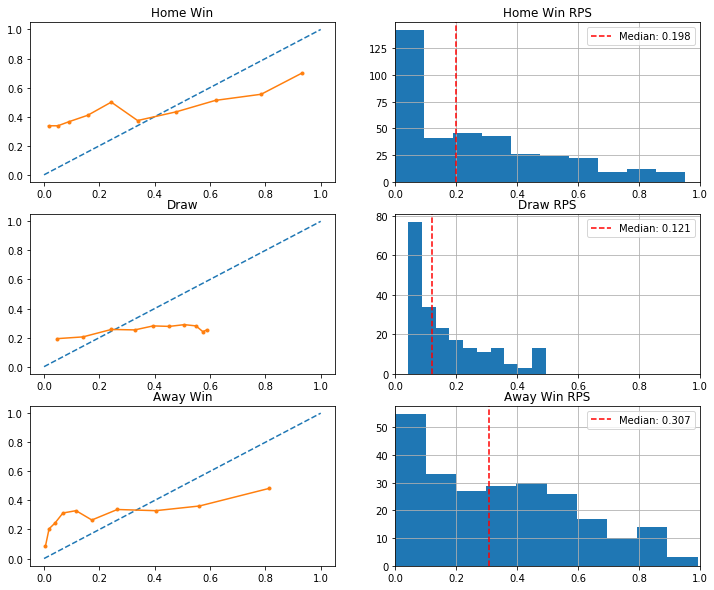


Validation Fold: 2
Average Calibration Error:  0.549
Expected Calibration Error: 0.383
Maximum Calibration Error:  0.939
Number of Instances: 827


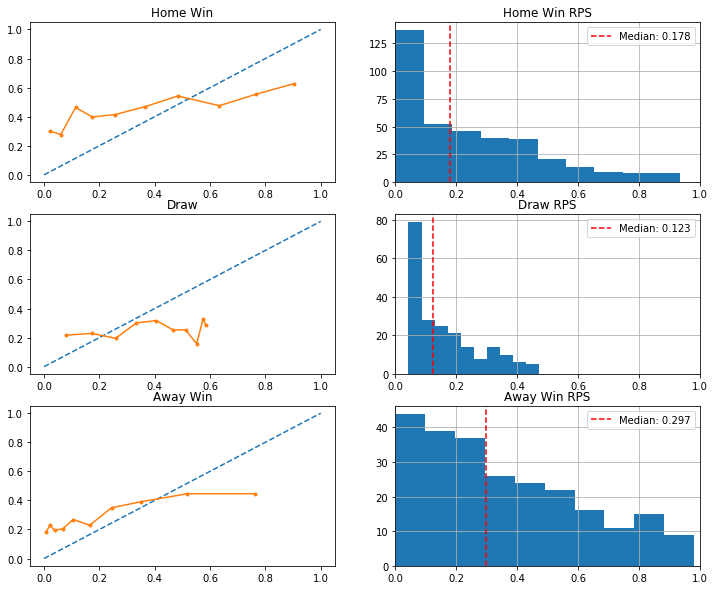


--------------------------------------------------------------------------------

LogisticAT(alpha=1.0, max_iter=1000, verbose=0): 1



/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.2

Validation Fold: 1
Average Calibration Error:  0.534
Expected Calibration Error: 0.477
Maximum Calibration Error:  0.906
Number of Instances: 827


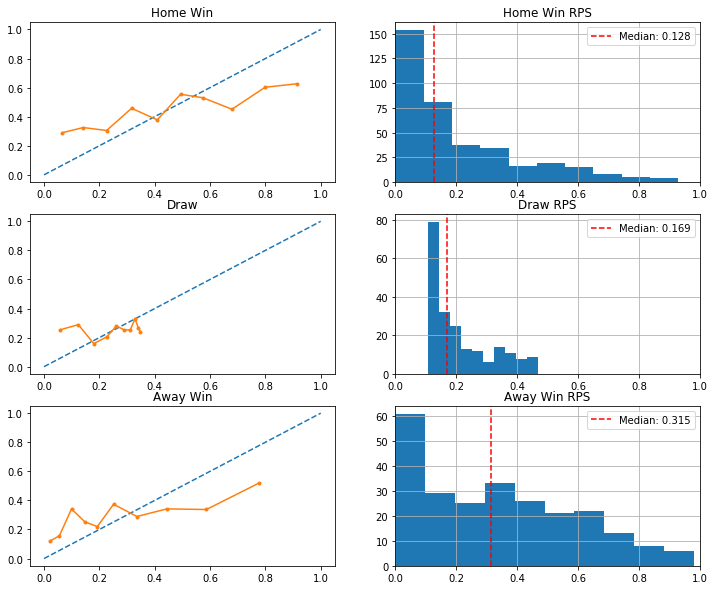


Validation Fold: 2
Average Calibration Error:  0.565
Expected Calibration Error: 0.502
Maximum Calibration Error:  0.940
Number of Instances: 827


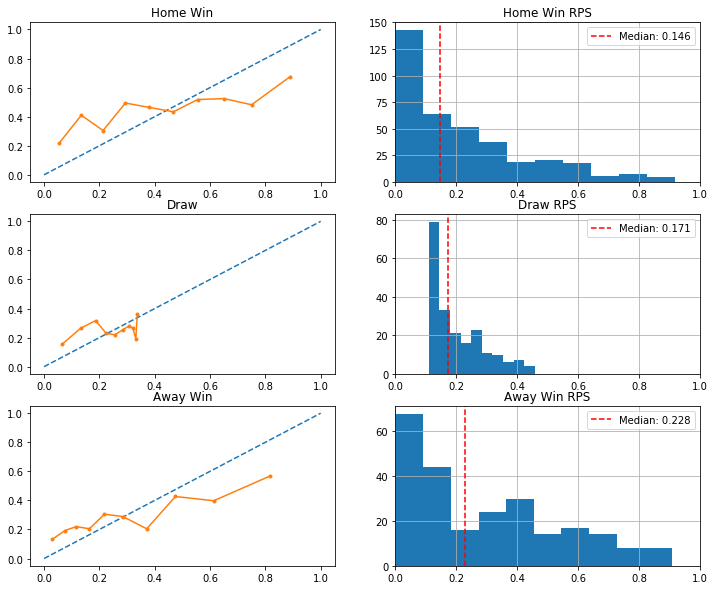


--------------------------------------------------------------------------------

LogisticIT(alpha=1.0, max_iter=1000, verbose=0): 2



/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.2

Validation Fold: 1
Average Calibration Error:  0.676
Expected Calibration Error: 0.598
Maximum Calibration Error:  0.888
Number of Instances: 827


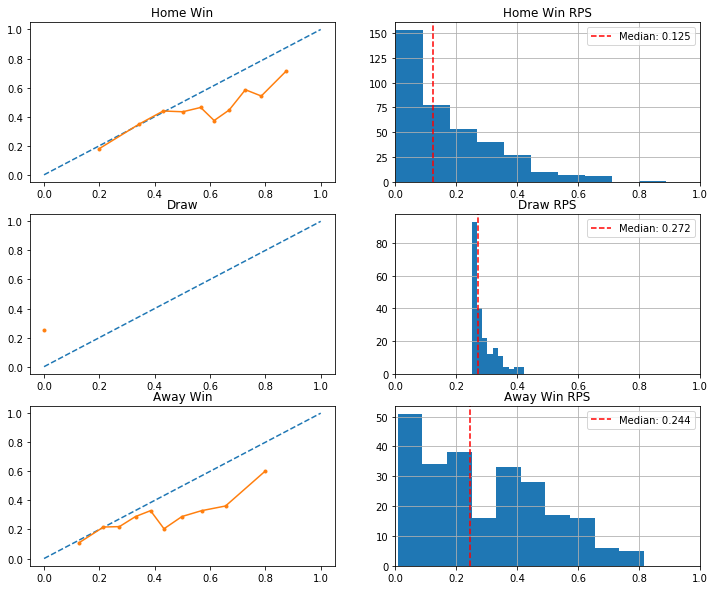


Validation Fold: 2
Average Calibration Error:  0.653
Expected Calibration Error: 0.580
Maximum Calibration Error:  0.930
Number of Instances: 827


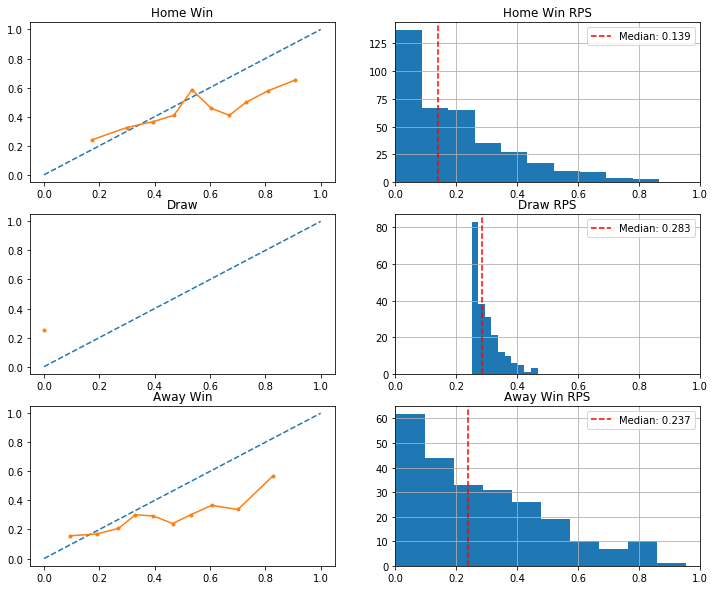


--------------------------------------------------------------------------------

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False): 3



/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.2

Validation Fold: 1
Average Calibration Error:  0.615
Expected Calibration Error: 0.456
Maximum Calibration Error:  0.926
Number of Instances: 827


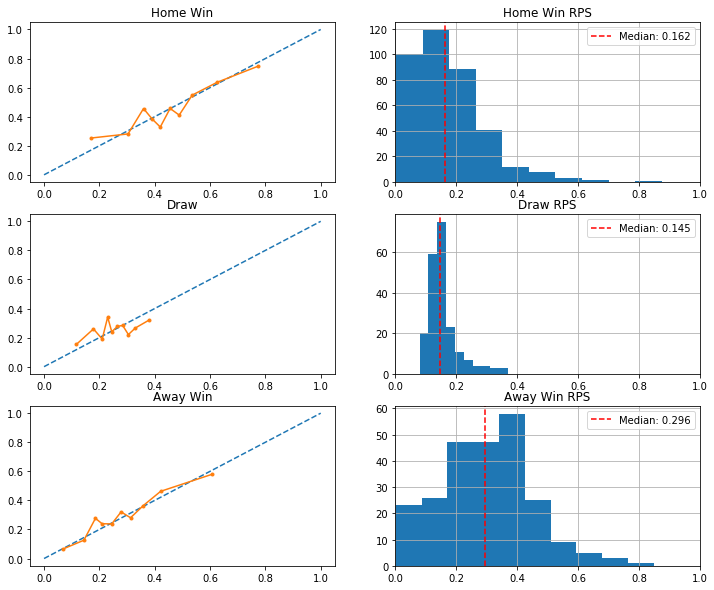


Validation Fold: 2
Average Calibration Error:  0.551
Expected Calibration Error: 0.398
Maximum Calibration Error:  0.844
Number of Instances: 827


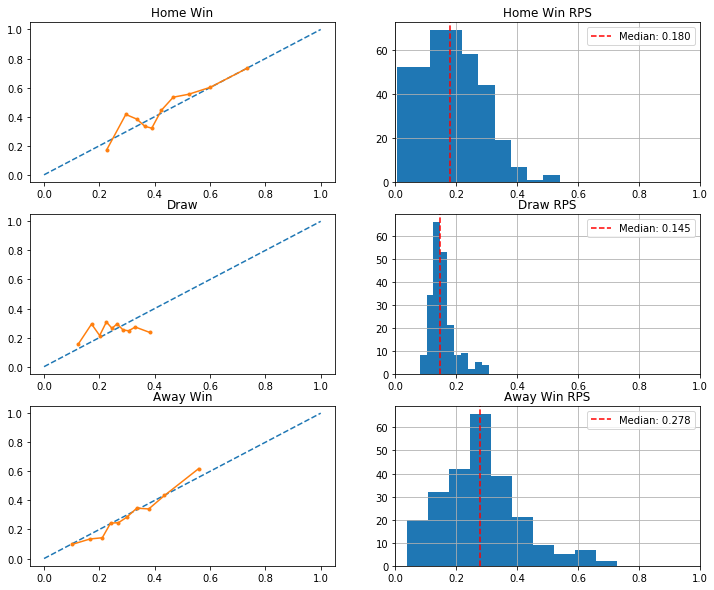


--------------------------------------------------------------------------------

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False): 4



/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.2

Validation Fold: 1
Average Calibration Error:  0.543
Expected Calibration Error: 0.484
Maximum Calibration Error:  0.855
Number of Instances: 827


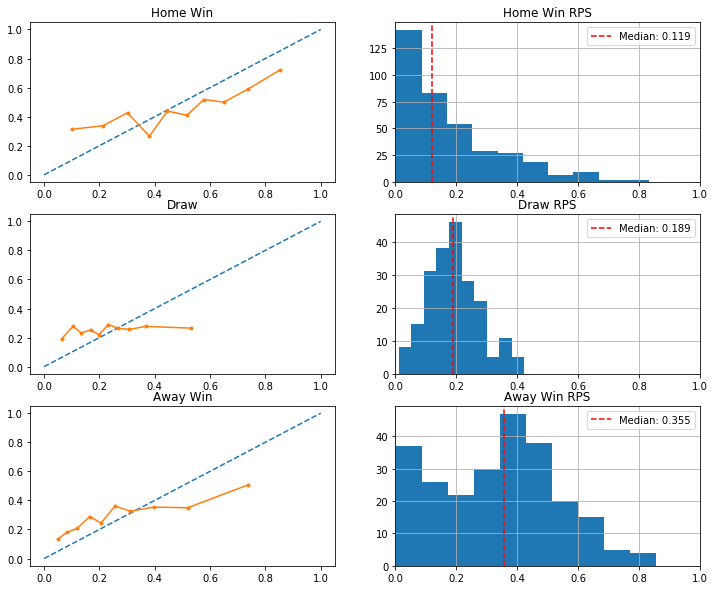


Validation Fold: 2
Average Calibration Error:  0.549
Expected Calibration Error: 0.474
Maximum Calibration Error:  0.922
Number of Instances: 827


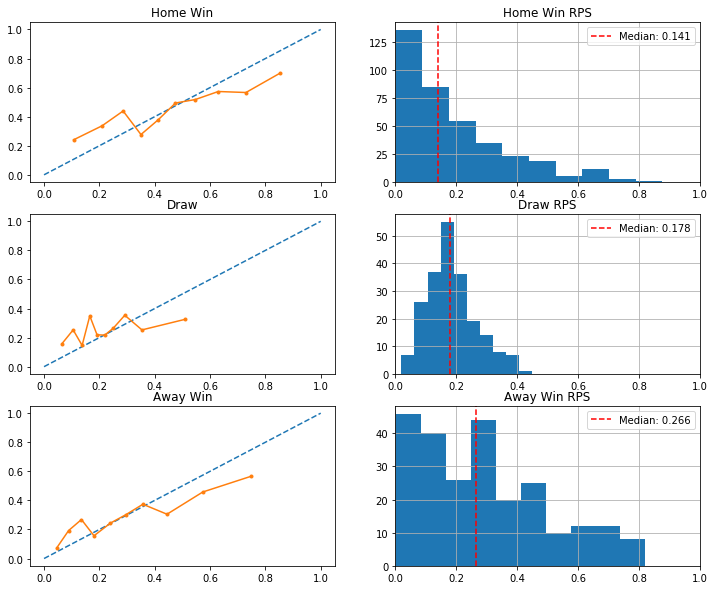


--------------------------------------------------------------------------------

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False): 5



/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.2

Validation Fold: 1
Average Calibration Error:  0.601
Expected Calibration Error: 0.409
Maximum Calibration Error:  0.913
Number of Instances: 827


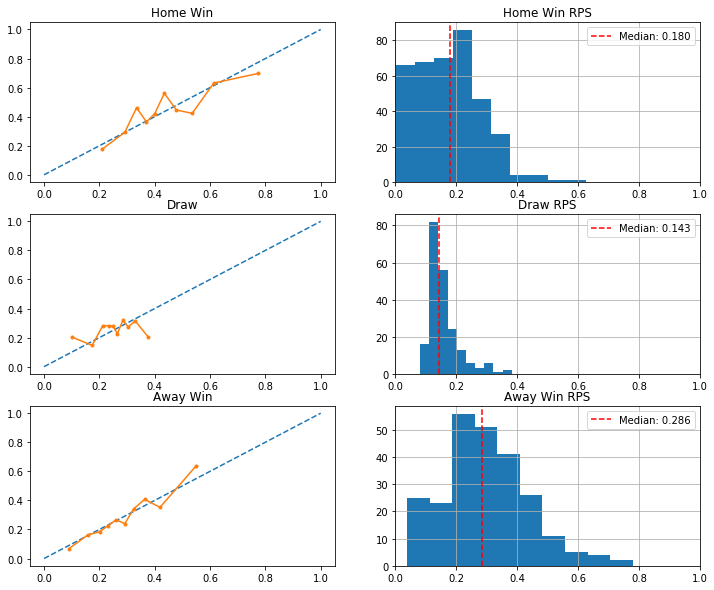


Validation Fold: 2
Average Calibration Error:  0.549
Expected Calibration Error: 0.417
Maximum Calibration Error:  0.837
Number of Instances: 827


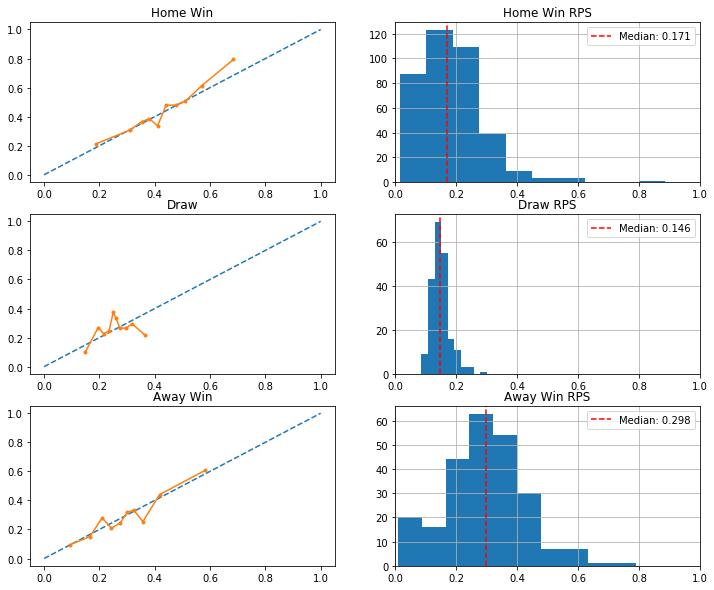


--------------------------------------------------------------------------------

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None): 6



/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.2

Validation Fold: 1
Average Calibration Error:  0.447
Expected Calibration Error: 0.181
Maximum Calibration Error:  0.740
Number of Instances: 827


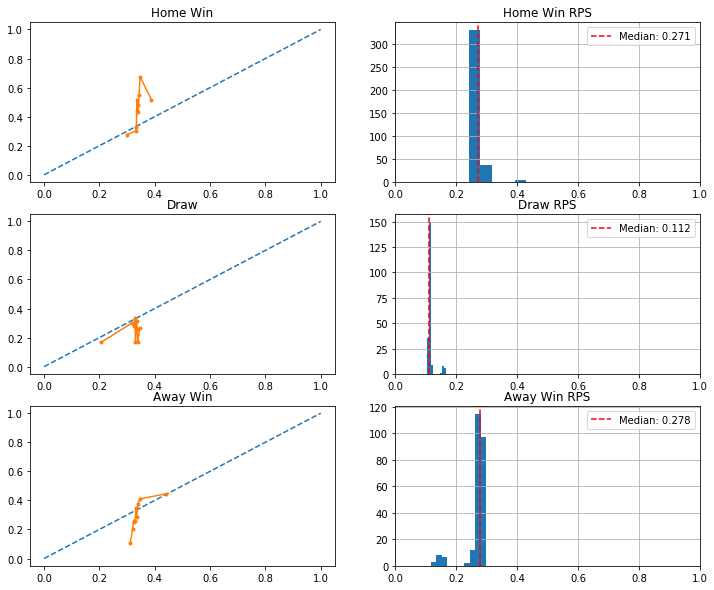


Validation Fold: 2
Average Calibration Error:  0.265
Expected Calibration Error: 0.184
Maximum Calibration Error:  0.506
Number of Instances: 827


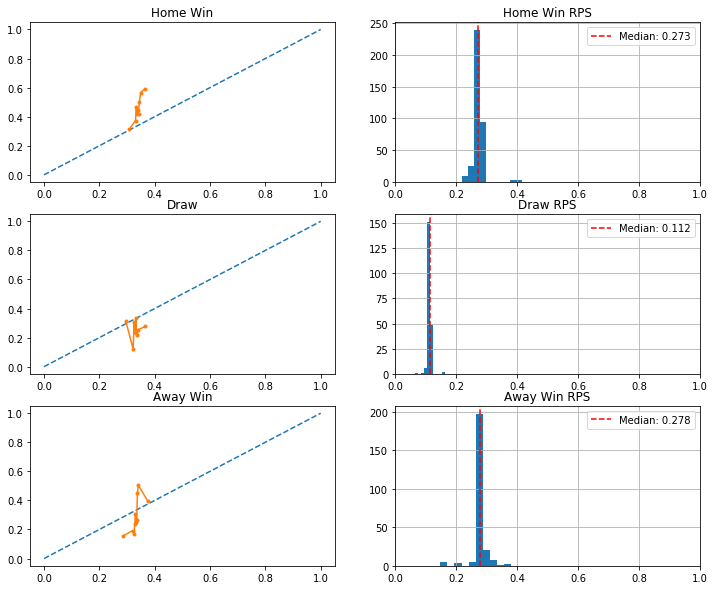


--------------------------------------------------------------------------------

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=0.4,
                           solver='eigen', store_covariance=False, tol=0.0001): 7



/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.2

Validation Fold: 1
Average Calibration Error:  0.485
Expected Calibration Error: 0.535
Maximum Calibration Error:  0.873
Number of Instances: 827


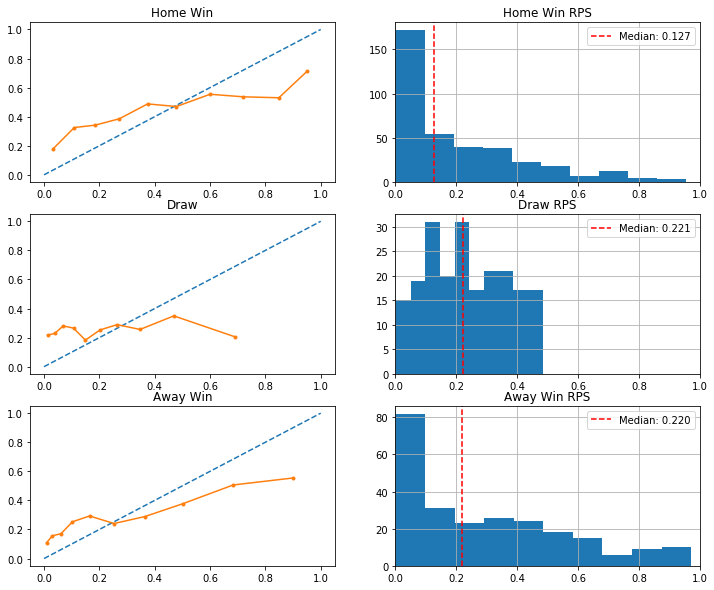


Validation Fold: 2
Average Calibration Error:  0.483
Expected Calibration Error: 0.499
Maximum Calibration Error:  0.907
Number of Instances: 827


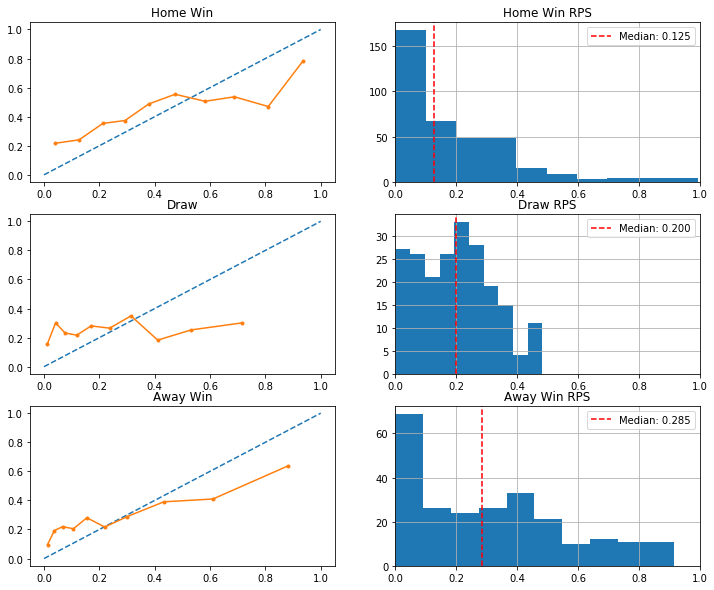


--------------------------------------------------------------------------------

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False): 8



/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be r

Validation Fold: 1
Average Calibration Error:  0.500
Expected Calibration Error: 0.497
Maximum Calibration Error:  0.882
Number of Instances: 827


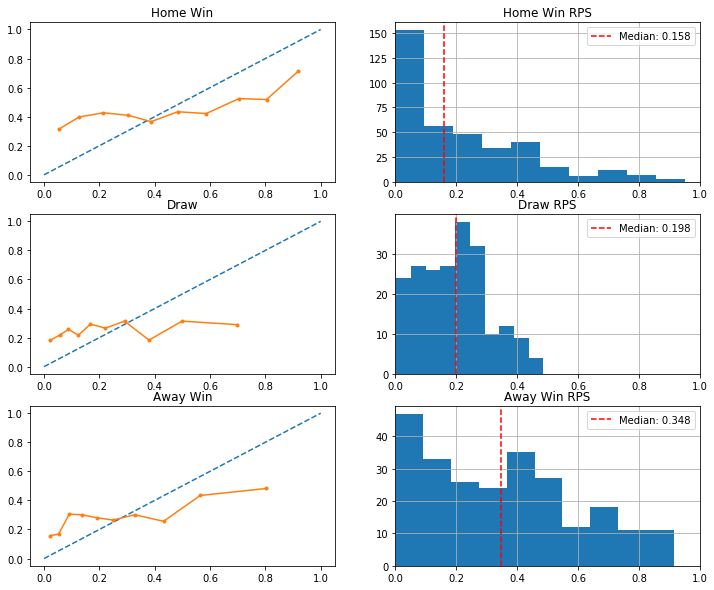


Validation Fold: 2
Average Calibration Error:  0.470
Expected Calibration Error: 0.455
Maximum Calibration Error:  0.883
Number of Instances: 827


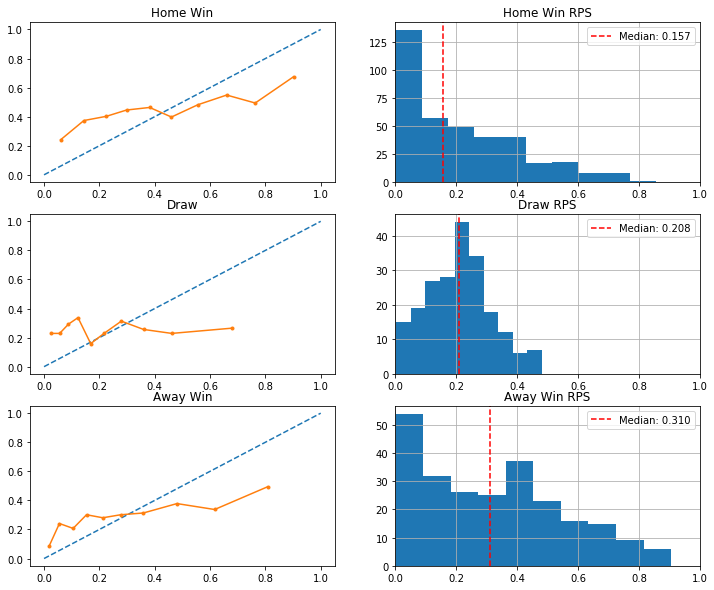


--------------------------------------------------------------------------------

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'): 9



/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.2

Validation Fold: 1
Average Calibration Error:  0.793
Expected Calibration Error: 0.793
Maximum Calibration Error:  0.793
Number of Instances: 827


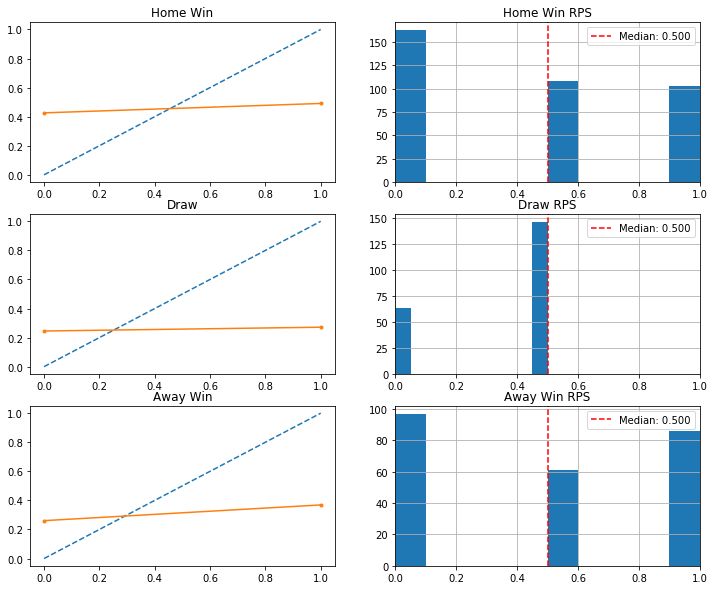


Validation Fold: 2
Average Calibration Error:  0.820
Expected Calibration Error: 0.820
Maximum Calibration Error:  0.820
Number of Instances: 827


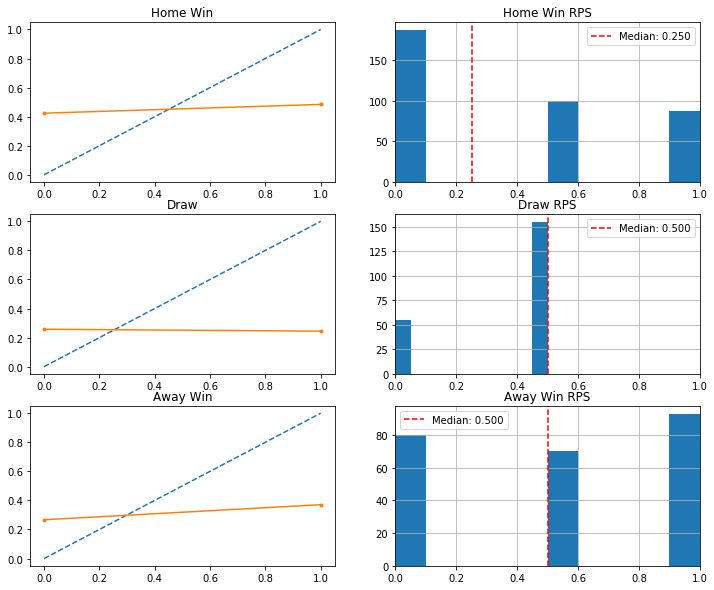


--------------------------------------------------------------------------------

GaussianProcessClassifier(copy_X_train=True, kernel=None, max_iter_predict=100,
                          multi_class='one_vs_rest', n_jobs=None,
                          n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
                          random_state=None, warm_start=False): 10



/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.2

Validation Fold: 1
Average Calibration Error:  0.300
Expected Calibration Error: 0.300
Maximum Calibration Error:  0.300
Number of Instances: 827


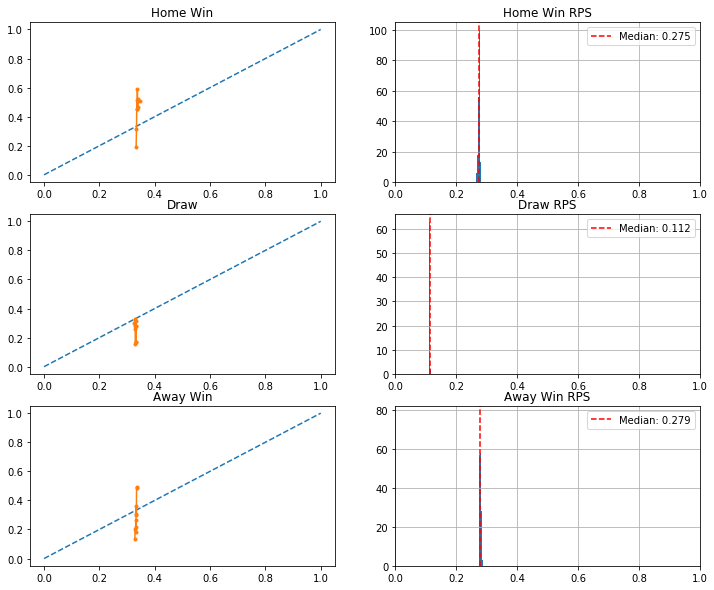


Validation Fold: 2
Average Calibration Error:  0.310
Expected Calibration Error: 0.310
Maximum Calibration Error:  0.310
Number of Instances: 827


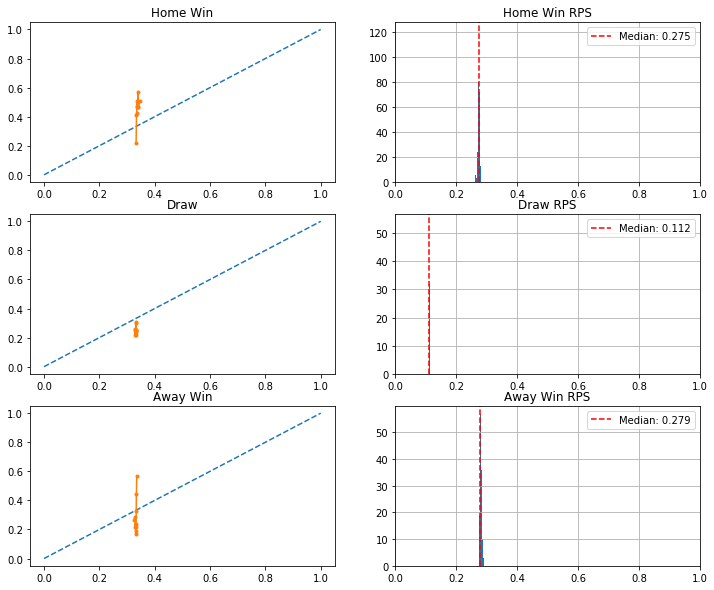


--------------------------------------------------------------------------------

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001): 11



/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/da

Validation Fold: 1
Average Calibration Error:  1.000
Expected Calibration Error: 1.000
Maximum Calibration Error:  1.000
Number of Instances: 827


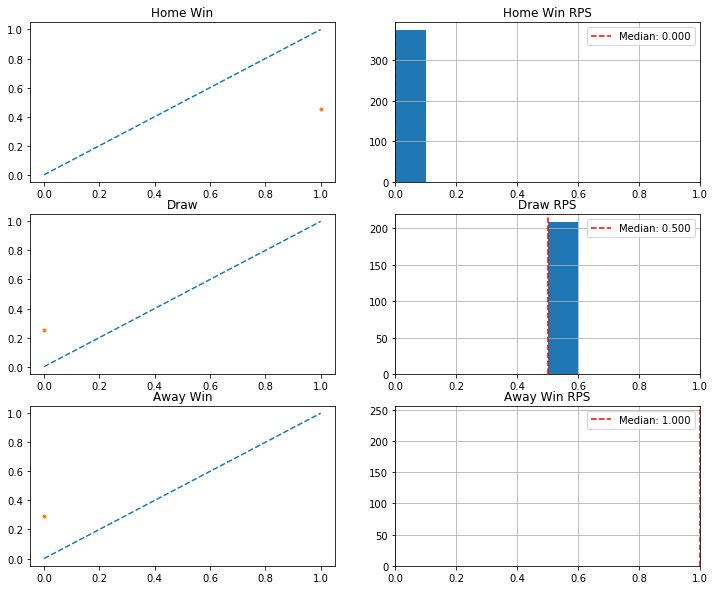


Validation Fold: 2
Average Calibration Error:  1.000
Expected Calibration Error: 1.000
Maximum Calibration Error:  1.000
Number of Instances: 827


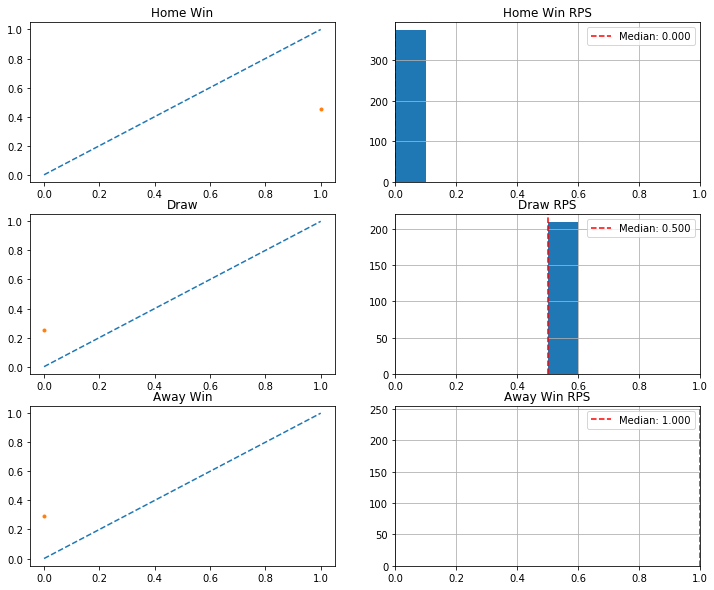


--------------------------------------------------------------------------------

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31,
               objective='multiclass', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0): 12



/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.2

Validation Fold: 1
Average Calibration Error:  0.535
Expected Calibration Error: 0.607
Maximum Calibration Error:  0.911
Number of Instances: 827


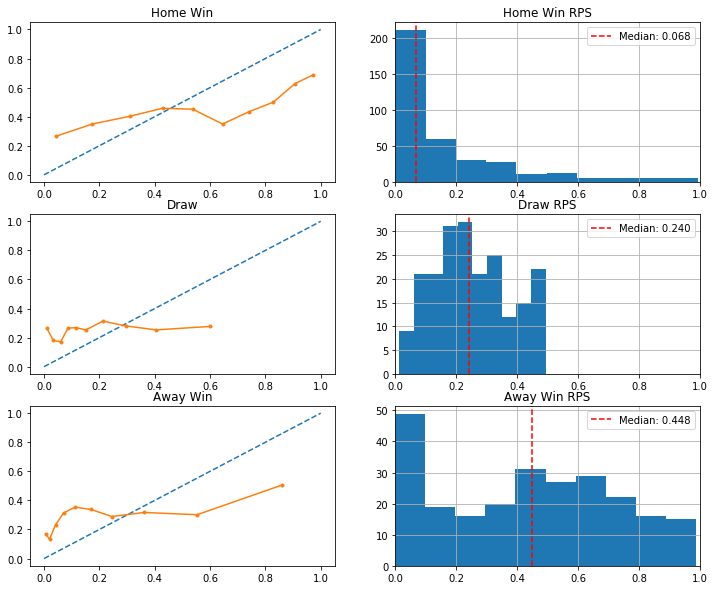


Validation Fold: 2
Average Calibration Error:  0.511
Expected Calibration Error: 0.566
Maximum Calibration Error:  0.930
Number of Instances: 827


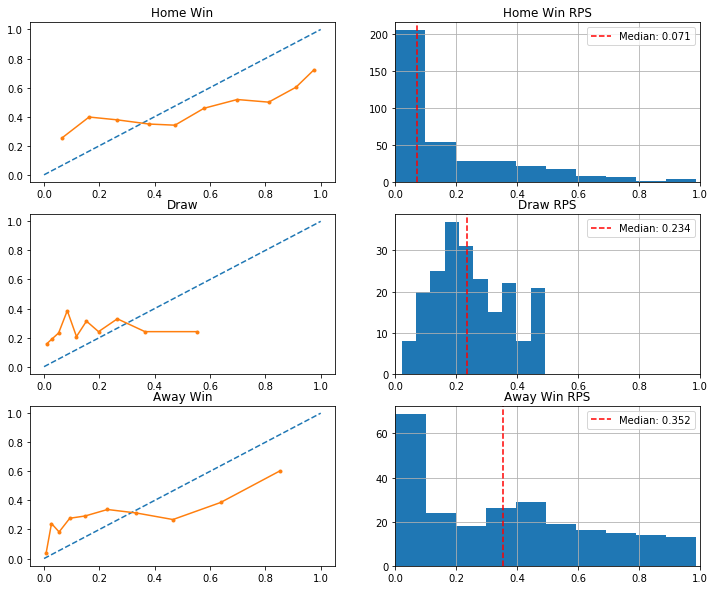


--------------------------------------------------------------------------------

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1): 13



/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.2

Validation Fold: 1
Average Calibration Error:  0.540
Expected Calibration Error: 0.447
Maximum Calibration Error:  0.809
Number of Instances: 827


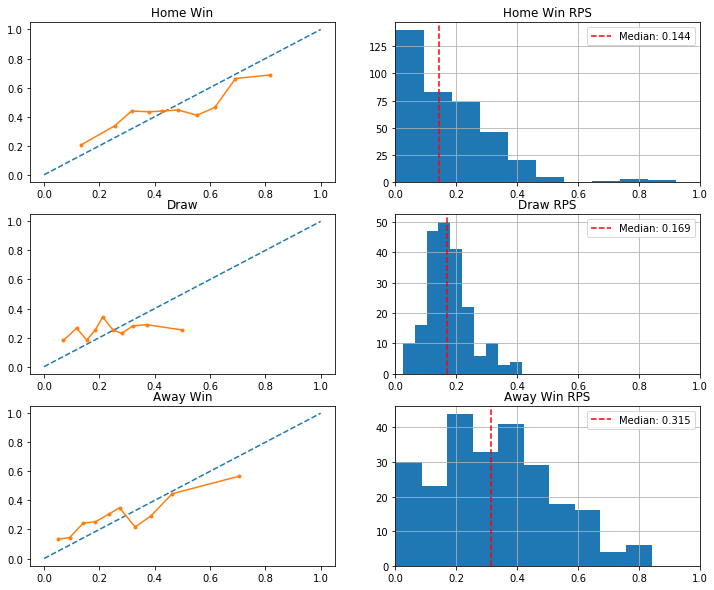


Validation Fold: 2
Average Calibration Error:  0.569
Expected Calibration Error: 0.464
Maximum Calibration Error:  0.920
Number of Instances: 827


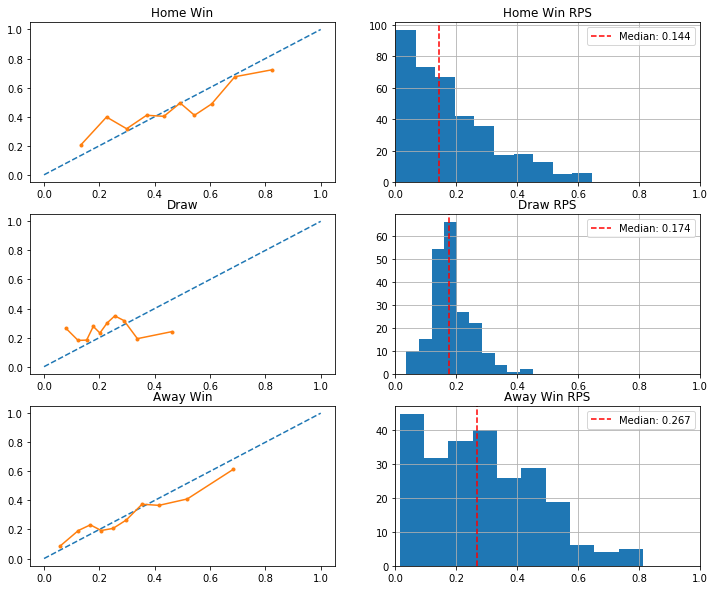


--------------------------------------------------------------------------------

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='distance'): 14



/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.2

Validation Fold: 1
Average Calibration Error:  0.574
Expected Calibration Error: 0.403
Maximum Calibration Error:  0.915
Number of Instances: 827


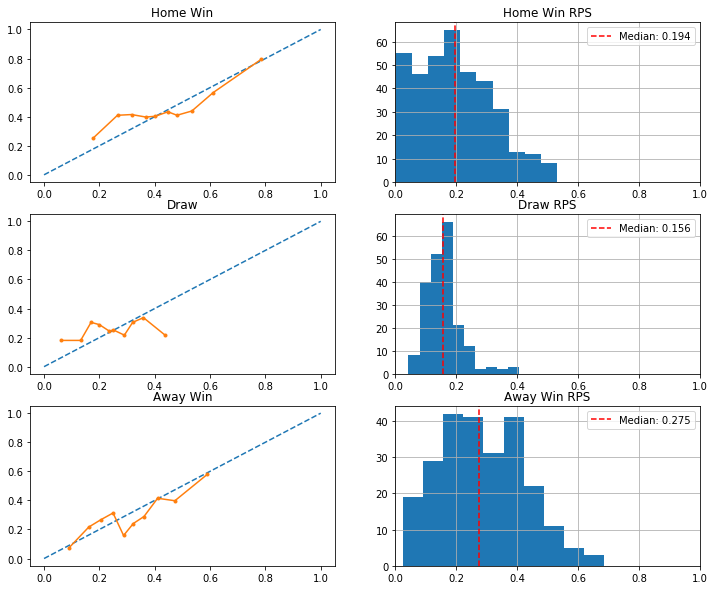


Validation Fold: 2
Average Calibration Error:  0.563
Expected Calibration Error: 0.466
Maximum Calibration Error:  0.841
Number of Instances: 827


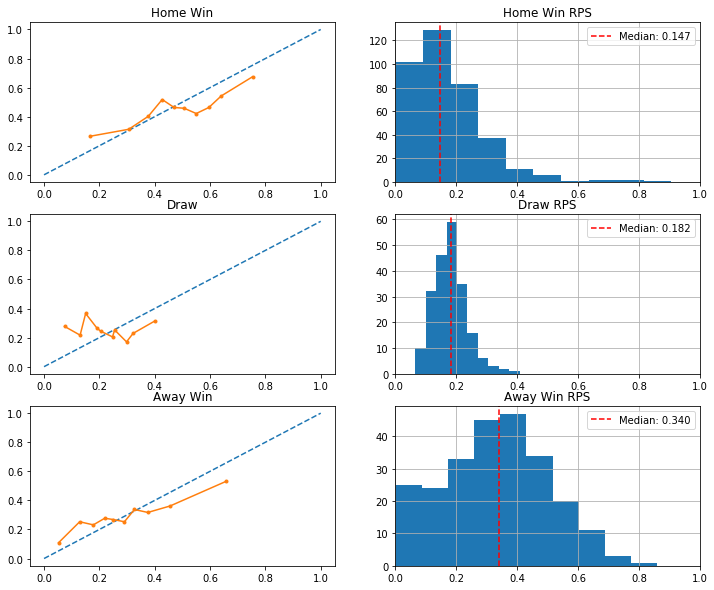


--------------------------------------------------------------------------------



In [23]:
from skoot.preprocessing import SelectiveMinMaxScaler
from sklearn.model_selection import StratifiedKFold

from sklearn.naive_bayes import MultinomialNB, CategoricalNB, GaussianNB
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              ExtraTreesClassifier, AdaBoostClassifier)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from lightgbm import LGBMClassifier 
from xgboost import XGBClassifier
from mord import LogisticSE, LogisticAT, LogisticIT
from sklearn.neighbors import KNeighborsClassifier

clfs = [LogisticSE(), LogisticAT(), LogisticIT(), RandomForestClassifier(),
       GradientBoostingClassifier(), ExtraTreesClassifier(), AdaBoostClassifier(),
       LinearDiscriminantAnalysis(solver='eigen', shrinkage=0.4),
       LogisticRegression(), DecisionTreeClassifier(),
       GaussianProcessClassifier(),
       QuadraticDiscriminantAnalysis(),
       LGBMClassifier(objective='multiclass'),
       XGBClassifier(objective="multi:softprob"),
       KNeighborsClassifier(n_neighbors=20, weights='distance', algorithm='brute')]


model_dict = {}
for i, clf in enumerate(clfs):
    print(f'{clf}: {i}')
    print()
    n_splits=2
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    srs = SelectiveMinMaxScaler(trans_col_name='')
    fitted_clf, dfs = run_fit_validate(X_train_val, y_train_val, meta_train_val, skf, srs, clf)
    # Pick up the model fitted to the last fold
    model_dict[i] = fitted_clf
    print('-'*80)
    print()


In [24]:
model_dict

{0: LogisticSE(alpha=1.0, max_iter=100000, verbose=0),
 1: LogisticAT(alpha=1.0, max_iter=1000, verbose=0),
 2: LogisticIT(alpha=1.0, max_iter=1000, verbose=0),
 3: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 4: GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.

## Best Model?

From visual inspection, I have ExtraTreesClassifier as the top, with close competition from RandomForest, LGBM, XGBoost, Logistic Regression, and Ordinal LogisticAT

In [25]:
# XtraTrees 5
# RandomForest 3
clf = model_dict[13]
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [26]:
joblib.dump(clf, SAMP_MODEL_FP)

['/media/david/5C14F53A14F517AA/code/ana_py37/projects/soccer-predictions/data/sample/models/optimized-model.joblib']

## 8. Simulate Gambling in Test Data

In [27]:
clf = joblib.load(SAMP_MODEL_FP)
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [28]:
# sig_clf = joblib.load(SAMP_CAL_FP)
# sig_clf

In [29]:
def predict_on_test(X_t, y_t, meta_t, srs, clf):
#     meta_t = meta_held_out_test.copy(deep=True)
#     X_t = X_held_out_test.copy(deep=True)
#     y_t = y_held_out_test.copy(deep=True)

    meta_t.reset_index(drop=True, inplace=True)
    X_t.reset_index(drop=True, inplace=True)
    y_t.reset_index(drop=True, inplace=True)
    
    
    X_t = srs.transform(X_t)
    test_preds = clf.predict_proba(X_t)
    test_preds_df = pd.DataFrame(test_preds, columns = clf.classes_)
    df_test = pd.concat([meta_t, X_t, test_preds_df], sort=False, axis=1)

    df_test['pred_class'] = df_test[[1,2, 3]].idxmax(axis=1)
    df_test['pred_result'] = df_test['pred_class'].map({1:'hwin', 2: 'draw', 3: 'awin'})

    df_test = insert_rps(df_test)
    df_test = insert_rps(df_test,
                             prob_cols=['implied_hwin', 'implied_draw', 'implied_awin'],
                             return_col_prefix='bookie')
    df_test = insert_rps(df_test,
                             prob_cols=['base_hwin_prob', 'base_draw_prob', 'base_awin_prob'],
                             return_col_prefix='baseline')
    return df_test

/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


Average Calibration Error:  0.537
Expected Calibration Error: 0.440
Maximum Calibration Error:  0.923
Number of Instances: 362


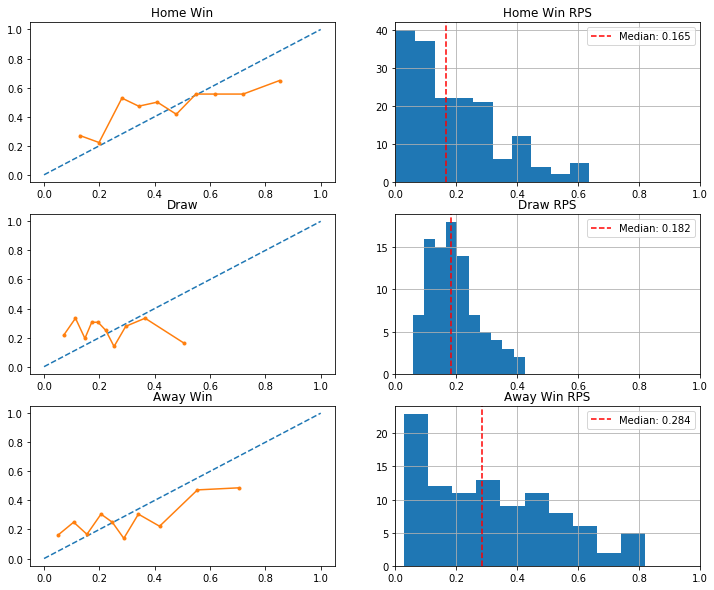

In [30]:
df = predict_on_test(X_held_out_test, y_held_out_test, meta_held_out_test, srs, clf)

get_model_diagnosis(df, add_baseline=True)
plt.show();

In [31]:
df = simulate_betting(df)

df.to_csv(SAVE_FP, index=False)

df.head(15)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,1,2,3,pred_class,pred_result,model_rps,bookie_rps,baseline_rps,hwin_unit_EV,draw_unit_EV,awin_unit_EV,hwin_bet,draw_bet,awin_bet,hwin_rets,draw_rets,awin_rets,placed_bet,game_ret
0,germany,bundesliga,2016-2017,ingolstadt,rb-leipzig,2016-12-10,1.0,0.0,hwin,4.0,16.0,0.0,0.253204,0.219288,0.527508,0.154623,0.072617,0.772724,0.0,13.0,3.0,4.0,1.80,1.75,1.85,1.80,0.275,0.275,0.45,3.75,3.75,3.75,3.63,3.0,19.0,1.0,0.253204,0.527508,0.219288,0.154623,0.772724,0.072617,1.0,4.0,1.0,1.0,4.33,4.75,5.00,4.62,0.527508,0.253204,0.219288,1,1,0,0,0.405229,0.611111,0.748441,0.748441,0.803296,0.911220,0.912575,0.903198,0.840152,0.734478,0.966452,0.893520,0.732903,0.680818,0.889666,0.636301,0.916914,0.764917,0.821674,0.857908,0.917475,0.828973,0.792699,0.908918,0.189643,0.637653,0.210208,0.261101,0.394816,0.445268,0.433339,0.160665,0.298709,0.295724,0.115038,0.148439,0.476736,0.750220,0.410320,0.172201,0.548895,0.294901,0.410888,0.367766,0.579914,0.316718,0.637653,0.189643,0.605516,0.499975,0.378078,0.325914,0.349632,0.634362,0.445142,0.464067,0.710108,0.663823,0.283463,0.117897,0.362172,0.631865,0.227133,0.475657,0.352508,0.416209,0.215402,0.445493,0.281398,0.281398,0.396557,0.558137,0.503040,0.737405,0.461039,0.299520,0.520817,0.652325,0.479066,0.058715,0.375148,0.241177,0.731973,0.278198,0.076687,0.285276,0.349823,2.231721,0.157274,0.350182,0.062167,0.850336,0.166058,0.184688,0.492801,0.389409,0.173247,0.091911,0.564640,0.277522,0.133067,0.011983,0.669134,0.862961,0.145462,0.028584,0.970831,0.796607,4.420762e-01,-6.570971e-13,8.017635e-01,2.020049e-01,0.850336,0.062167,0.669009,0.609262,0.317907,0.301779,0.633653,0.782234,0.215250,0.458647,0.657193,0.974674,0.174313,0.052827,0.535834,0.852138,0.004851,0.085226,2.365479e-01,-0.001588,7.866320e-02,5.336208e-01,0.357143,0.444444,0.285714,0.235294,0.642857,0.157895,0.846154,0.166667,0.428571,0.30,0.000000,0.105263,0.285714,0.333333,0.214286,0.40,0.428571,0.263158,0.214286,0.30,0.454545,0.448276,0.419355,0.310345,0.387097,0.384615,0.387097,0.413793,0.419355,0.517241,0.172414,0.592593,0.466667,0.413793,0.666667,0.655172,0.400000,0.40,0.354839,0.571429,0.571429,0.222222,0.125,0.111111,0.500000,0.375,0.166667,0.000,0.285714,0.500000,0.000000,0.333333,0.166667,0.250,0.142857,0.125,0.166667,0.142857,0.

pred hwin: 12.490000000000002 on 145 bets
pred draw: -17.18 on 79 bets
pred awin: -22.08 on 132 bets
356 bets returning -26.77 over 362 games
Overall Return: -0.075

On Sided t Test Against against Mean = 0:
	t_stat:	-0.912
	p_val:	0.181


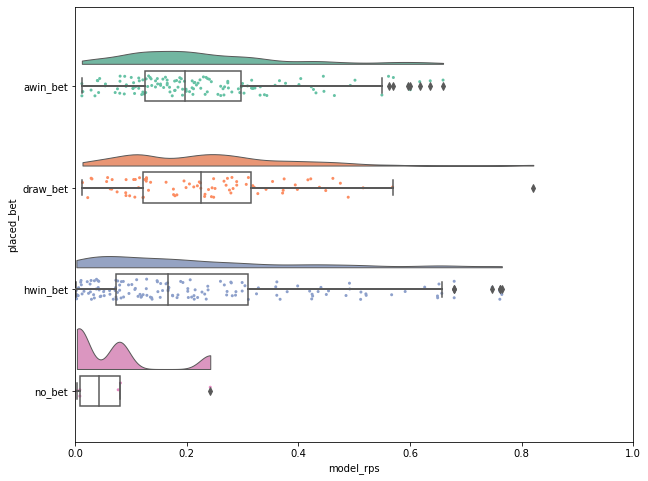

In [32]:
import ptitprince as pt
from scipy.stats import ttest_1samp

def get_betting_diagnosis(df):
    fig, ax = plt.subplots(figsize=(10,8))
    ax = pt.RainCloud(x='placed_bet', y='model_rps', data=df, width_viol=0.8, width_box=0.3,
                  orient='h', pointplot=False)
    ax.set_xlim(0.0, 1.0)
    
    bet_rets = pd.concat([df['hwin_rets'], df['draw_rets'], df['awin_rets']], axis=0)
    bet_rets = bet_rets[bet_rets != 0].values
    res = ttest_1samp(bet_rets, 0)
    t_stat = res[0]
    p_val = res[1]/2
    
    # Swarm Plot on Probabilities her
    # sns.catplot(x="day", y="total_bill", kind="swarm", data=tips);
    
    n_bets = df[["hwin_bet" , "draw_bet", "awin_bet"]].sum().sum()
    print(f'pred hwin: {df["hwin_rets"].sum()} on {df["hwin_bet"].sum()} bets')
    print(f'pred draw: {df["draw_rets"].sum()} on {df["draw_bet"].sum()} bets')
    print(f'pred awin: {df["awin_rets"].sum()} on {df["awin_bet"].sum()} bets')
    print(f'{n_bets} bets returning {df["game_ret"].sum()} over {len(df)} games')
    print(f'Overall Return: {df["game_ret"].sum()/n_bets:.3f}')
    print()
    print(f'On Sided t Test Against against Mean = 0:\n\tt_stat:\t{t_stat:.3f}\n\tp_val:\t{p_val:.3f}')
    return fig, ax


get_betting_diagnosis(df)
plt.show();

In [33]:
df[df['placed_bet'] != 'no_bet'].head(25)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,1,2,3,pred_class,pred_result,model_rps,bookie_rps,baseline_rps,hwin_unit_EV,draw_unit_EV,awin_unit_EV,hwin_bet,draw_bet,awin_bet,hwin_rets,draw_rets,awin_rets,placed_bet,game_ret
0,germany,bundesliga,2016-2017,ingolstadt,rb-leipzig,2016-12-10,1.0,0.0,hwin,4.0,16.0,0.0,0.253204,0.219288,0.527508,0.154623,0.072617,0.772724,0.0,13.0,3.0,4.0,1.80,1.75,1.85,1.80,0.275,0.275,0.45,3.75,3.75,3.75,3.63,3.0,19.0,1.0,0.253204,0.527508,0.219288,0.154623,0.772724,0.072617,1.0,4.0,1.0,1.0,4.33,4.75,5.00,4.62,0.527508,0.253204,0.219288,1,1,0,0,0.405229,0.611111,0.748441,0.748441,0.803296,0.911220,0.912575,0.903198,0.840152,0.734478,0.966452,0.893520,0.732903,0.680818,0.889666,0.636301,0.916914,0.764917,0.821674,0.857908,0.917475,0.828973,0.792699,0.908918,0.189643,0.637653,0.210208,0.261101,0.394816,0.445268,0.433339,0.160665,0.298709,0.295724,0.115038,0.148439,0.476736,0.750220,0.410320,0.172201,0.548895,0.294901,0.410888,0.367766,0.579914,0.316718,0.637653,0.189643,0.605516,0.499975,0.378078,0.325914,0.349632,0.634362,0.445142,0.464067,0.710108,0.663823,0.283463,0.117897,0.362172,0.631865,0.227133,0.475657,0.352508,0.416209,0.215402,0.445493,0.281398,0.281398,0.396557,0.558137,0.503040,0.737405,0.461039,0.299520,0.520817,0.652325,0.479066,0.058715,0.375148,0.241177,0.731973,0.278198,0.076687,0.285276,0.349823,2.231721,0.157274,0.350182,0.062167,0.850336,0.166058,0.184688,0.492801,0.389409,0.173247,0.091911,0.564640,0.277522,0.133067,0.011983,0.669134,0.862961,0.145462,0.028584,0.970831,0.796607,4.420762e-01,-6.570971e-13,8.017635e-01,2.020049e-01,0.850336,0.062167,0.669009,0.609262,0.317907,0.301779,0.633653,0.782234,0.215250,0.458647,0.657193,0.974674,0.174313,0.052827,0.535834,0.852138,0.004851,0.085226,2.365479e-01,-0.001588,7.866320e-02,5.336208e-01,0.357143,0.444444,0.285714,0.235294,0.642857,0.157895,0.846154,0.166667,0.428571,0.30,0.000000,0.105263,0.285714,0.333333,0.214286,0.40,0.428571,0.263158,0.214286,0.30,0.454545,0.448276,0.419355,0.310345,0.387097,0.384615,0.387097,0.413793,0.419355,0.517241,0.172414,0.592593,0.466667,0.413793,0.666667,0.655172,0.400000,0.40,0.354839,0.571429,0.571429,0.222222,0.125,0.111111,0.500000,0.375,0.166667,0.000,0.285714,0.500000,0.000000,0.333333,0.166667,0.250,0.142857,0.125,0.166667,0.142857,0.

In [34]:
df[df['placed_bet'] != 'no_bet'].tail(25)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,1,2,3,pred_class,pred_result,model_rps,bookie_rps,baseline_rps,hwin_unit_EV,draw_unit_EV,awin_unit_EV,hwin_bet,draw_bet,awin_bet,hwin_rets,draw_rets,awin_rets,placed_bet,game_ret
337,germany,bundesliga,2017-2018,hertha-berlin,augsburg,2018-04-28,2.0,2.0,draw,3.0,14.0,1.0,0.289800,0.461691,0.248509,0.282686,0.465670,0.251644,1.0,12.0,3.0,2.0,3.79,3.60,3.80,3.60,0.275,0.275,0.45,3.25,3.30,3.58,3.39,6.0,9.0,0.0,0.289800,0.248509,0.461691,0.282686,0.251644,0.465670,0.0,8.0,5.0,0.0,2.04,2.15,2.17,2.09,0.248509,0.289800,0.461691,2,0,1,0,0.934641,1.000000,0.893778,0.893778,0.908891,0.914414,0.880436,0.795322,0.527077,0.615162,0.826791,0.868983,0.846858,0.969859,0.990987,0.909163,0.583420,0.880049,0.796659,0.865056,0.762798,0.851627,0.218839,0.890771,0.471501,0.287768,0.442141,0.315462,0.526506,0.277457,0.718599,0.778458,0.583980,0.300954,0.455867,0.371260,0.376415,0.291794,0.724144,0.459752,0.603829,0.276008,0.581148,0.280717,0.923358,0.400194,0.287768,0.471501,0.318228,0.448201,0.248641,0.513732,0.141535,0.097375,0.184168,0.466400,0.314124,0.375087,0.359202,0.463210,0.130318,0.330725,0.175776,0.491089,0.216521,0.491363,0.029334,0.371748,0.584438,0.584438,0.582019,0.572345,0.652798,0.459961,0.432959,0.378305,0.592138,0.645236,0.542012,0.603159,0.671891,0.522794,0.400716,0.477966,0.515203,0.390165,0.235186,0.577969,0.157097,0.277128,0.485762,0.268984,0.412341,0.205563,0.472954,0.146002,0.572451,0.724020,0.403524,0.231964,0.402832,0.262388,0.216712,0.188504,0.635757,0.305339,0.526968,0.173504,0.481022,0.176780,0.803470,0.318242,0.268984,0.485762,0.329200,0.582978,0.276280,0.668194,0.234973,0.129620,0.341431,0.507494,0.354675,0.486345,0.492020,0.585937,0.196072,0.485103,0.245846,0.643611,0.319346,0.574407,0.077090,0.477850,0.357143,0.222222,0.000000,0.352941,0.071429,0.052632,0.384615,0.222222,0.428571,0.40,0.428571,0.263158,0.214286,0.444444,0.428571,0.30,0.500000,0.210526,0.142857,0.00,0.484848,0.448276,0.419355,0.344828,0.225806,0.615385,0.548387,0.413793,0.419355,0.344828,0.379310,0.148148,0.366667,0.275862,0.400000,0.413793,0.433333,0.44,0.290323,0.321429,0.000000,0.222222,0.375,0.222222,0.000000,0.125,0.166667,0.000,0.428571,0.166667,0.285714,0.000000,0.166667,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.125,0.0,0.2,0.00,0.